# 311 Requests and Metro Proximity (LA)

**Goal**: Analyze whether proximity to metro rail infrastructure correlates with the volume or type of 311 requests in Los Angeles.

This notebook:
- Loads and cleans 311 request data
- Joins with Neighborhood Council and population data
- Computes distance to nearest metro stop
- Visualizes request patterns spatially and temporally

Builds on work by [@priyakalyan](https://github.com/priyakalyan) and Hack for LA contributors.
Analysis uses 2024 data from HuggingFace and LA GeoHub.

# Section 1: Setup

In [37]:
# Install necessary packages and run only once per environment

# !pip install geopandas shapely folium pyproj datasets matplotlib seaborn pandas requests

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from shapely.geometry import Point

In [3]:
from pathlib import Path

# Start from the current notebook location
nb_dir = Path().resolve()

# To the project root
project_root = nb_dir.parent

DATA_RAW = project_root / "data" / "raw"
DATA_CLEANED = project_root / "data" / "cleaned"

# Section 2: Load 311 Data (2024)

In [4]:
# Load LA 311 service requests dataset from HuggingFace if available, 1,442,290 records, 34 columns

In [5]:
# Fetch data from huggingface, as of now the 2024 is the latest dataset available https://huggingface.co/datasets/311-data/2024, datasets available from 2020-2024 so far

dataset = load_dataset("311-data/2024", split="train")
df_311 = dataset.to_pandas()
print("Loaded 2024 subset of 311 data:", df_311.shape)


Loaded 2024 subset of 311 data: (1442290, 34)


# Section 3: Load Metro Data

In [6]:
# Manual step: Download most recent metro stop shapefiles from: (this has been done and the file is available under data/cleaned)
# https://geohub.lacity.org/datasets/metro-rail-lines-stops last updated June 7, 2018, 107 records

In [7]:
# Metro Rail Lines Stops Fields: from https://maps.lacity.org/lahub/rest/services/Metro_Bus_and_Rail/MapServer/1
# OBJECTID ( type: esriFieldTypeOID, alias: OBJECTID )
# MetroLine ( type: esriFieldTypeString, alias: MetroLine, length: 100 )
# Station ( type: esriFieldTypeString, alias: Station, length: 100 )
# StopNumber ( type: esriFieldTypeInteger, alias: StopNumber )
# Shape ( type: esriFieldTypeGeometry, alias: Shape )
# TOOLTIP ( type: esriFieldTypeString, alias: TOOLTIP, length: 249 )
# NLA_URL ( type: esriFieldTypeString, alias: NLA_URL, length: 8000 )

In [8]:
metro_stops = gpd.read_file(DATA_CLEANED / 'Metro_Rail_Lines_Stops/Metro_Rail_Lines_Stops.shp')
# metro_stops = gpd.read_file('data/raw/Metro_Rail_Lines_Stops/Metro_Rail_Lines_Stops.shp')

# Section 4: Load Neighborhood Councils and Population Data

In [9]:
# Updated NC shapefile: https://geohub.lacity.org/datasets/neighborhood-councils/
# last updated Oct 14, 2020
# 99 records

# Updated NC boundaries: https://geohub.lacity.org/datasets/lahub::neighborhood-council-boundaries-2018/about
# last updated Jan 19, 2023
# 99 records

# Instead of going the ACS Census tract or zip code route, Priya has already tried the Census tract route here https://github.com/priyakalyan/Updated_NC_pop/blob/main/NC_pop_recent_no_filter.ipynb and found the join on census tract and NC boundary and then reattribution for split NCs creates an inflated population number
# the NC website has shared a PDF report for each NC and stored it here https://neighborhoodempowerment.lacity.gov/data/ -> https://drive.google.com/drive/folders/1uupIXEGEC8UlFOCQiyIPH9q7JmETn_Cx
# The specific file we are interested in is https://drive.google.com/file/d/1lM0HYvY3ZhQnbDd0m9uwAtFtstQOL9Zx/view?usp=drive_link
# I've added it to data/raw will extract the necessary information and add it to data/cleaned
# This data is sourced from ACS demographic data - 2018, 5 year estimate and updated end of Jan 2020.



In [10]:
import pdfplumber
import pandas as pd
import re

pdf_path = DATA_CLEANED / '99 NCs Demographic Data Sheet.pdf'

nc_blocks = []
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        if text:
            nc_blocks.append(text.strip())

records = []

for block in nc_blocks:
    lines = block.split("\n")

    try:
        nc_name = lines[0].strip()                       # Line 1: NC name
        total_population = int(lines[2].replace(",", ""))  # Line 3: Total Population

        # Median income via regex
        income_match = re.search(r"Median Household Income\s*\$\s*([^\n]+)", block)
        if income_match:

            digits_only = re.sub(r"[^\d]", "", income_match.group(1))
            median_income = int(digits_only)
        else:
            median_income = None

        records.append({
            "NC_Name": nc_name,
            "Population": total_population,
            "Median_Income": median_income
        })

    except Exception as e:
        print(f"Error parsing block for NC: {lines[0] if lines else 'UNKNOWN'} | {e}")

# Convert to DataFrame and inspect
df = pd.DataFrame(records)
df.head()


,NC_Name,Population,Median_Income
0,Arleta,36823,73506
1,Arroyo Seco,19861,68962
2,Atwater Village,14694,68734
3,Bel Air-Beverly Crest,27734,200001
4,Boyle Heights,87002,37391


In [11]:
# use nc_blocks[] to manually verify the data and also pdf can be accessed visa the link above to cross-check the data as needed
df["NC_Name"] = df["NC_Name"].replace({
    "Historic Cultural": "Arts District Little Tokyo"
}) # changing this to match the NC shape file and the latest name maintained by the NC https://www.hcnc-adlt.org/hoodinfo
df


,NC_Name,Population,Median_Income
0,Arleta,36823,73506
1,Arroyo Seco,19861,68962
2,Atwater Village,14694,68734
3,Bel Air-Beverly Crest,27734,200001
4,Boyle Heights,87002,37391
...,...,...,...
94,Wilmington,55688,47521
95,Wilshire Center Koreatown,106190,38149
96,Winnetka,48459,70474
97,Woodland Hills-Warner Center,76422,96692


In [12]:
df.to_csv(DATA_CLEANED / 'nc_demographics_2020.csv', index=False)
print("\nSaved cleaned demographic table with", len(df), "rows.")


Saved cleaned demographic table with 99 rows.


In [13]:
nc_geo = gpd.read_file(DATA_CLEANED / 'Neighborhood_Council_Boundaries_(2018)/Neighborhood_Council_Boundaries_(2018).shp')

In [14]:
nc_geo["NC_Name"] = nc_geo["Name"]
nc_geo_merged = nc_geo.merge(df, on="NC_Name", how="left")

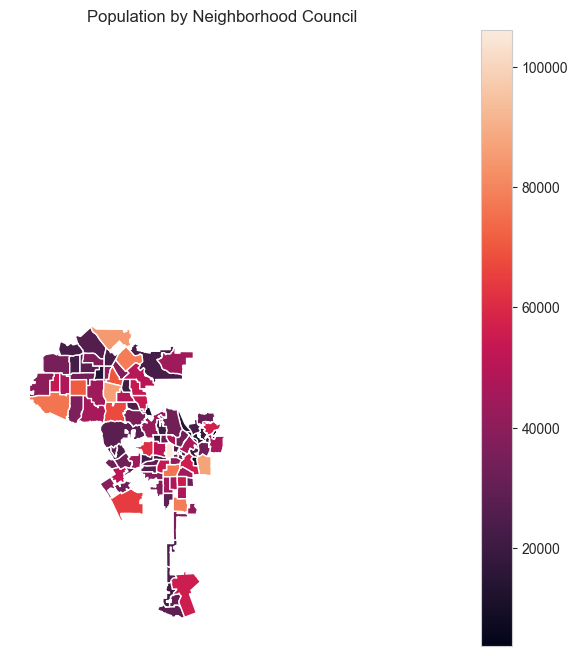

In [15]:
nc_geo_merged.plot(column="Population", legend=True, figsize=(12, 8))
plt.title("Population by Neighborhood Council")
plt.axis("off")
plt.show()

In [16]:
total_pop = nc_geo_merged["Population"].sum()
print(f"Total LA NC population: {total_pop:,}")

# Total LA NC population: 3,904,696
# This aligns with https://data.census.gov/profile/Los_Angeles_city,_California?g=160XX00US0644000
# where reported population of LA city in 2020 Decennial Census is 3,898,747
# we are good to proceed with this data

Total LA NC population: 3,904,696


# Section 5: Calculate Population Density

In [18]:
# WGS84 (EPSG:4326) uses degrees, not meters, bad for area. Reproject to something like EPSG:2229 (LA-specific) or EPSG:3857 (meters).

nc_proj = nc_geo_merged.to_crs(epsg=3857)

In [19]:
# Area in square meters
nc_proj["Area_m2"] = nc_proj.geometry.area

# Convert to square miles (1 mi² = 2,589,988.11 m²)
nc_proj["Area_mi2"] = nc_proj["Area_m2"] / 2_589_988.11

# Population Density per mi²
nc_proj["Pop_Density_per_mi2"] = nc_proj["Population"] / nc_proj["Area_mi2"]


nc_proj[["NC_Name", "Population", "Area_mi2", "Pop_Density_per_mi2"]].head()


,NC_Name,Population,Area_mi2,Pop_Density_per_mi2
0,Arleta,36823,4.805567,7662.571511
1,Arroyo Seco,19861,4.487741,4425.611620
2,Atwater Village,14694,12.837963,1144.574147
3,Bel Air-Beverly Crest,27734,24.835302,1116.716843
4,Boyle Heights,87002,8.371049,10393.202099


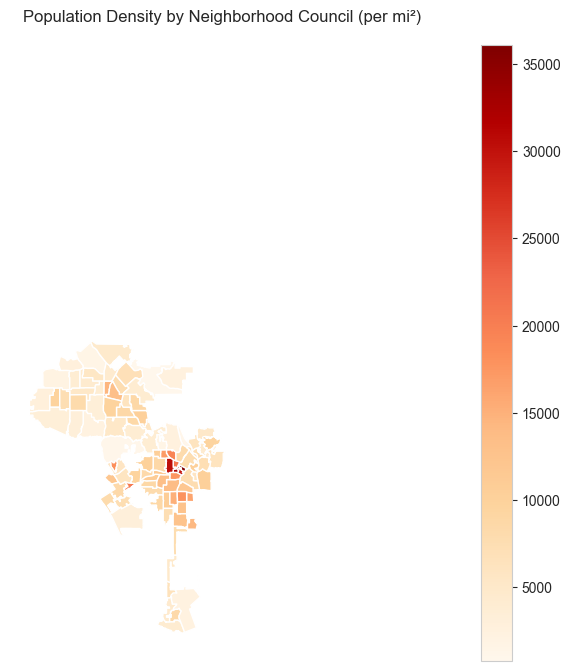

In [20]:
nc_proj.plot(column="Pop_Density_per_mi2", legend=True, figsize=(12, 8), cmap="OrRd")
plt.title("Population Density by Neighborhood Council (per mi²)")
plt.axis("off")
plt.show()


# Section 6: Spatial Join Between 311 Requests and NC Data

In [22]:
from shapely.geometry import Point
import geopandas as gpd

# Drop rows without coordinates
df_311_2024 = df_311.dropna(subset=["Latitude", "Longitude"])
#1442290 to 1440902

# Create Point geometries
geometry = [Point(xy) for xy in zip(df_311_2024["Longitude"], df_311_2024["Latitude"])]
gdf_311 = gpd.GeoDataFrame(df_311_2024, geometry=geometry, crs="EPSG:4326")


In [23]:
gdf_311_proj = gdf_311.to_crs(nc_proj.crs)

# Only keep requests that physcially fall within a NC boundary
gdf_311_joined = gpd.sjoin(gdf_311_proj, nc_proj, how="inner", predicate="within")
#1440902 to 1418336

In [24]:
# Compare NCName mismatches for curiosity

mismatches = gdf_311_joined[gdf_311_joined["NCName"] != gdf_311_joined["NC_Name"]]
print("Label mismatch examples:\n", mismatches[["NCName", "NC_Name"]].dropna())

Label mismatch examples:
                             NCName                    NC_Name
2                    Mid-City West              Mid City West
5        Foothills Trails District   Foothill Trails District
23       Foothills Trails District   Foothill Trails District
45                 Rampart Village  Wilshire Center Koreatown
48                     Arroyo Seco            Lincoln Heights
...                            ...                        ...
1442279                Zapata-King                Zapata King
1442281             Westlake South             MacArthur Park
1442283                Zapata-King                Zapata King
1442285             MacArthur Park             Westlake South
1442289                      LA-32                       LA32

[121285 rows x 2 columns]


In [25]:
gdf_311_joined = gdf_311_joined.rename(columns={"NC_Name": "NC_Assigned"})


After cleaning and joining the 2024 LA 311 dataset to Neighborhood Council (NC) boundaries:

- Original 311 records: 1,442,290
- After dropping records missing latitude/longitude: 1,440,902
- After spatial join with NC boundaries: 1,418,336
  - These requests are physically located within an LA Neighborhood Council boundary.
  - ~22,566 requests were dropped for falling outside official NC boundaries (likely unincorporated areas or bad geocoding).

Label Comparison: `NCName` vs Spatially Assigned `NC_Name`
- 121,285 requests (~8.4%) had mismatches between the original `NCName` field and the spatially joined `NC_Name`.
- Decision: Use the spatially assigned `NC_Name` (renamed `NC_Assigned`) as the authoritative label going forward, since it accurately reflects geographic location.

This ensures downstream metrics like per capita request rates or spatial models are geographically consistent and trustworthy.


In [26]:
gdf_311_proj = gdf_311_joined.to_crs(nc_proj.crs)

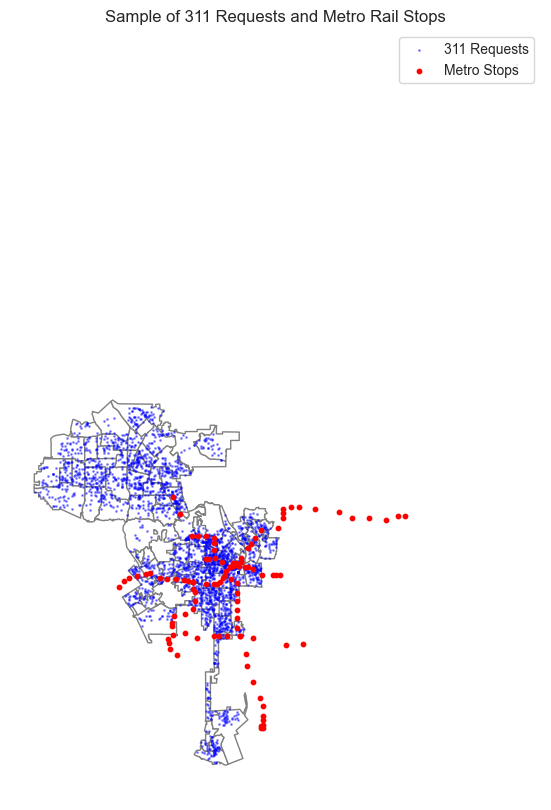

In [27]:
# --- Sampled Requests in the NC boundary overlaid with Metro stops ---
sample_311 = gdf_311_proj.sample(3000, random_state=42)

# Plot
ax = nc_proj.plot(color="white", edgecolor="gray", figsize=(12, 10))
sample_311.plot(ax=ax, markersize=1, color="blue", alpha=0.4, label="311 Requests")
metro_stops.plot(ax=ax, color="red", markersize=10, label="Metro Stops")
plt.title("Sample of 311 Requests and Metro Rail Stops")
plt.legend()
plt.axis("off")
plt.show()

/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_40965/1943965570.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nc_choropleth = nc_proj.merge(nc_counts, left_on="NC_Name", right_on="NC_Assigned", how="left").fillna(0)


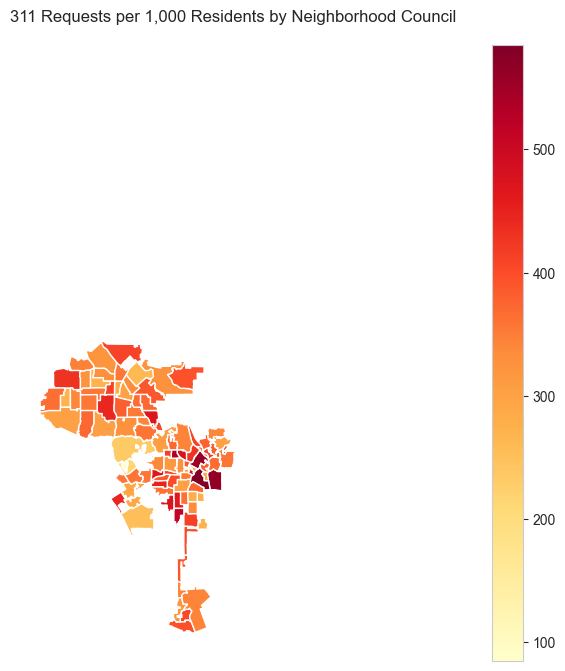

In [28]:
# --- Requests per 1000 Residents by Neighborhood Council (Choropleth) ---
nc_counts = gdf_311_joined.groupby("NC_Assigned").size().reset_index(name="Request_Count")
nc_choropleth = nc_proj.merge(nc_counts, left_on="NC_Name", right_on="NC_Assigned", how="left").fillna(0)
nc_choropleth["Requests_per_1000"] = nc_choropleth["Request_Count"] / nc_choropleth["Population"] * 1000


nc_choropleth.plot(column="Requests_per_1000", cmap="YlOrRd", legend=True, figsize=(12, 8))
plt.title("311 Requests per 1,000 Residents by Neighborhood Council")
plt.axis("off")
plt.show()


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_40965/3465819194.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nc_viz = nc_proj.merge(req_counts, left_on="NC_Name", right_on="NC_Assigned", how="left").fillna(0)


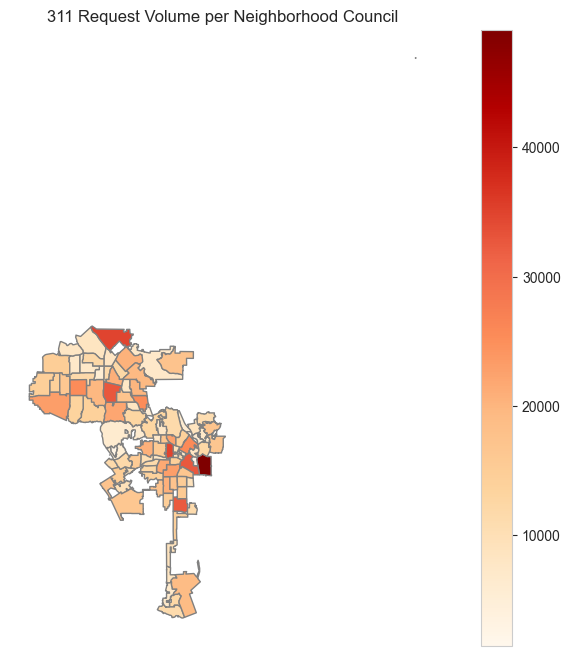

In [29]:
# --- Requests per Neighborhood Council (Raw Count Choropleth) ---
req_counts = gdf_311_proj.groupby("NC_Assigned").size().reset_index(name="Request_Count")
nc_viz = nc_proj.merge(req_counts, left_on="NC_Name", right_on="NC_Assigned", how="left").fillna(0)

nc_viz.plot(column="Request_Count", cmap="OrRd", legend=True, figsize=(12, 8), edgecolor="gray")
plt.title("311 Request Volume per Neighborhood Council")
plt.axis("off")
plt.show()

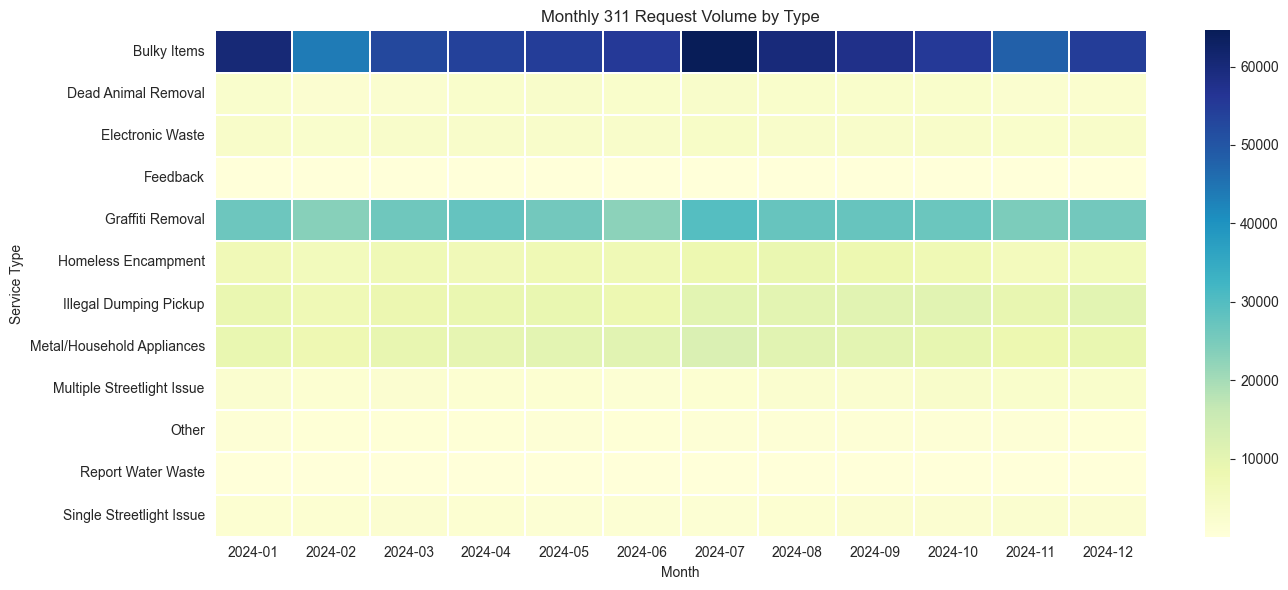

In [30]:
# --- Temporal Heatmap (Monthly) ---
gdf_311_proj['created_month'] = gdf_311_proj['CreatedDate'].dt.to_period("M")
temporal_counts = gdf_311_proj.groupby(['created_month', 'RequestType']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(temporal_counts.T, cmap="YlGnBu", linewidths=0.1)
plt.title("Monthly 311 Request Volume by Type")
plt.xlabel("Month")
plt.ylabel("Service Type")
plt.tight_layout()
plt.show()

# Section 7: Join 311 Requests To Metro Stops

In [32]:
metro_proj = metro_stops.to_crs(nc_proj.crs)

(107, 7)


<Axes: >

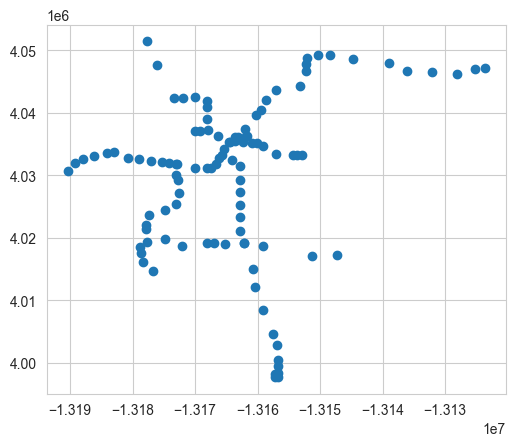

In [33]:
print(metro_stops.shape)
metro_stops.plot()

In [34]:
from shapely.ops import nearest_points

# Create a unary union of metro geometries for fast lookup
metro_union = metro_proj.union_all()

# Compute distance in meters from each request to nearest metro stop
gdf_311_proj["DistToMetro_m"] = gdf_311_proj.geometry.apply(
    lambda geom: geom.distance(nearest_points(geom, metro_union)[1])
)

# Convert distance to feet (1 meter ≈ 3.28084 feet)
gdf_311_proj["DistToMetro_ft"] = gdf_311_proj["DistToMetro_m"] * 3.28084

# Flag requests within walkable buffer zones
gdf_311_proj["Within_500ft"] = gdf_311_proj["DistToMetro_ft"] <= 500
gdf_311_proj["Within_1000ft"] = gdf_311_proj["DistToMetro_ft"] <= 1000
gdf_311_proj["Within_1320ft"] = gdf_311_proj["DistToMetro_ft"] <= 1320   # ~0.25 mile
gdf_311_proj["Within_2640ft"] = gdf_311_proj["DistToMetro_ft"] <= 2640   # ~0.5 mile

# Summary stats
print("Distance Summary (feet):")
print(gdf_311_proj["DistToMetro_ft"].describe())

print("\nShare of requests within 0.25 mile of metro (1320 ft):")
print(f"{gdf_311_proj['Within_1320ft'].mean():.2%}")

print("\nShare of requests within 0.5 mile of metro (2640 ft):")
print(f"{gdf_311_proj['Within_2640ft'].mean():.2%}")


Distance Summary (feet):
count    1.418336e+06
mean     2.295046e+04
std      2.509015e+04
min      1.363879e+01
25%      4.265087e+03
50%      1.060852e+04
75%      3.810670e+04
max      1.054428e+05
Name: DistToMetro_ft, dtype: float64

Share of requests within 0.25 mile of metro (1320 ft):
3.76%

Share of requests within 0.5 mile of metro (2640 ft):
12.73%


Text(0.5, 0, 'Feet')

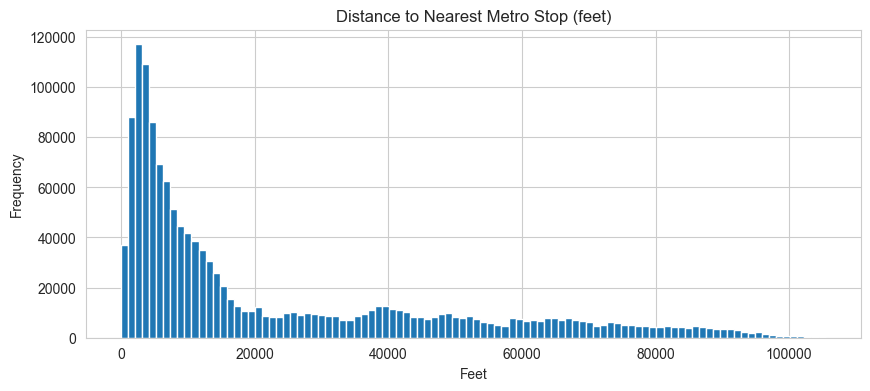

In [35]:
gdf_311_proj["DistToMetro_ft"].plot.hist(bins=100, figsize=(10,4))
plt.title("Distance to Nearest Metro Stop (feet)")
plt.xlabel("Feet")


In [36]:
gdf_311_proj["Within_2640ft"].value_counts()

Within_2640ft
False    1237804
True      180532
Name: count, dtype: int64